In [4]:
from pathlib import Path
import numpy as np
from numpy.random import shuffle, seed
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg
import os
import gc

from xfoil import XFoil
from xfoil.model import Airfoil

from lib.utils import load_pkl, save_pkl
from config import *
from lib.dl_modules import *
from lib.preprocess_modules import interpolate_airfoil, get_alfa_step
from nets.nn import nn_2561024
from tensorflow.keras.metrics import MeanIoU
from datetime import datetime

from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau


# create new dataset
create_dataset = False

# check available resolutions
bitmap_outputs

[(256, 1024), (512, 512)]

In [2]:
# %load_ext tensorboard
%reload_ext tensorboard
logdir = os.path.join("logs", datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=logdir,  profile_batch = 100000000)

## Create dataset

In [10]:
if create_dataset:
    
    bitmap_output_number = 0

    # create dataset for selected bitmap output
    pkl_folder = str(bitmap_outputs[bitmap_output_number][0])+'x'+str(bitmap_outputs[bitmap_output_number][1])

    # dataset config
    incl_data = { 'Cl'  : True,
                  'Cd'  : True,
                  'Cm'  : True,
                  'Cp'  : True,
                  'd'   : True,
                  'S'   : True,
                  'Re'  : False,
                  'alfa': False }

    # count samples amount
    samples_amount = len(os.listdir(Path(foils_bmp_path, pkl_folder)))
    
    actual_samples_amt = 0
    for fname in os.listdir(Path(foils_bmp_path, pkl_folder)): 
        if sample>samples_amount-1:break
        if fname not in foil_exception_list:
            actual_samples_amt+=1
    samples_amount = actual_samples_amt    
    # samples_amount = 138

    # count data layers
    n_data_layers = 0
    for key in incl_data.keys():
        if incl_data[key]: n_data_layers+=1       
    
    print('Total samples: %i, layers in sample: %i.' % (samples_amount, n_data_layers))
    print('Taking data from %s folder...' % pkl_folder)

    X = np.zeros((samples_amount, n_data_layers, n_points_Re, n_points_alfa), dtype='float64')
    y = np.zeros((samples_amount, bitmap_outputs[bitmap_output_number][0], bitmap_outputs[bitmap_output_number][1], 1), dtype='int8')

    print('Created empty arrays: X(%s) and y(%s), import data...' % (X.shape, y.shape))

    sample = 0

    for fname in os.listdir(Path(foils_bmp_path, pkl_folder)): 

        if sample>samples_amount-1:break

        if fname not in foil_exception_list:

            foil = load_pkl(Path(foils_pkl_path, fname))

            ind_X=0

            for i, key in enumerate(incl_data):
                if incl_data[key]:
                    X[sample, ind_X, :, :] = foil['X'][i, :, :]
                    ind_X+=1   
            y[sample, :, :, :] = np.expand_dims(load_pkl(Path(foils_bmp_path, pkl_folder, fname)), 2)
            sample+=1

        else:
            print('%s excluded.' % fname)

    # reshaping X 
    X = X.reshape(samples_amount, n_data_layers*n_points_Re*n_points_alfa)

    assert np.sum(np.isnan(X))==0, "NaNs in X"
    assert np.sum(np.isnan(y))==0, "NaNs in y"

    print('Saving...')

    save_pkl(X, Path(dataset_folder, "X.pkl"))
    save_pkl(y, Path(dataset_folder, "y.pkl"))

    del X, y
    gc.collect()

    print('Done.')
    print("Totally foils in arrays: %i" % (sample))

## Load dataset, prepare indices

In [2]:
X = load_pkl(Path(dataset_folder, 'X.pkl'))
y = load_pkl(Path(dataset_folder, 'y.pkl'))
X.shape, y.shape

all_indices = np.arange(len(X))
seed(42)
shuffle(all_indices)

n_indices = len(X)
train_part = int(n_indices*train_percentage)
val_part = int(n_indices*val_percentage)
train_part, val_part
train_indices = all_indices[:train_part]
val_indices = all_indices[train_part:val_part]
test_indices = all_indices[val_part:]

## Train with Tversky loss, BS=16

In [6]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 1764), started 0:04:26 ago. (Use '!kill 1764' to kill it.)

In [9]:
n_epochs   = 10000
batch_size = 16
lr         = 1e-3
verbose    = 1

model = nn_2561024(X.shape[1], learning_rate=lr, loss=tversky_loss, metrics=['mse', MeanIoU(num_classes=2)],verbose=1)

# data generators
train_generator = BatchGenerator(X, y, train_indices, batch_size=batch_size, Xdim=X[0].shape, ydim=y[0].shape)
val_generator   = BatchGenerator(X, y, val_indices, batch_size=batch_size, Xdim=X[0].shape, ydim=y[0].shape)
test_generator  = BatchGenerator(X, y, test_indices, batch_size=1, Xdim=X[0].shape, ydim=y[0].shape, shuffle=False)

early_stop = EarlyStopping(monitor='loss', patience=30, restore_best_weights=True, verbose=verbose)
lr_reduce  = ReduceLROnPlateau(monitor='loss', min_lr=0, cooldown=10, factor=0.2, patience=10, verbose=verbose, mode='min')

history = model.fit_generator(generator=train_generator, validation_data=val_generator, 
                             epochs=n_epochs, callbacks=[early_stop, lr_reduce,tensorboard_callback],#, m_save],                              
                             verbose=verbose, workers=1, use_multiprocessing=False)

# save history and weights
r_name = 'Weights for 256x1024 with Tversky loss and BS=16'+" "+(str(datetime.now())[:16]).replace(':','-')
model.save_weights(str(Path('weights', r_name+'.h5')))
save_pkl(history.history, Path('weights', r_name+'.pkl'))

LDM net output shape: (None, 256, 1024, 1)
Epoch 1/10000
28/28 [==============================] - 10s 375ms/step - loss: 0.5887 - mse: 0.1783 - mean_io_u_2: 0.4115 - val_loss: 0.6243 - val_mse: 0.2190 - val_mean_io_u_2: 0.4086
Epoch 2/10000
28/28 [==============================] - 10s 349ms/step - loss: 0.5150 - mse: 0.1416 - mean_io_u_2: 0.4466 - val_loss: 0.5631 - val_mse: 0.1902 - val_mean_io_u_2: 0.4108
Epoch 3/10000
28/28 [==============================] - 10s 347ms/step - loss: 0.4548 - mse: 0.1183 - mean_io_u_2: 0.6736 - val_loss: 0.5065 - val_mse: 0.1723 - val_mean_io_u_2: 0.7693
Epoch 4/10000
28/28 [==============================] - 10s 347ms/step - loss: 0.4103 - mse: 0.1018 - mean_io_u_2: 0.8421 - val_loss: 0.4662 - val_mse: 0.1373 - val_mean_io_u_2: 0.8318
Epoch 5/10000
28/28 [==============================] - 10s 350ms/step - loss: 0.3650 - mse: 0.0841 - mean_io_u_2: 0.8802 - val_loss: 0.4173 - val_mse: 0.1083 - val_mean_io_u_2: 0.8565
Epoch 6/10000
28/28 [================

28/28 [==============================] - 10s 345ms/step - loss: 0.0448 - mse: 0.0146 - mean_io_u_2: 0.9470 - val_loss: 0.0595 - val_mse: 0.0201 - val_mean_io_u_2: 0.9334
Epoch 46/10000
28/28 [==============================] - 10s 367ms/step - loss: 0.0458 - mse: 0.0150 - mean_io_u_2: 0.9458 - val_loss: 0.0631 - val_mse: 0.0218 - val_mean_io_u_2: 0.9324
Epoch 47/10000
28/28 [==============================] - 10s 351ms/step - loss: 0.0434 - mse: 0.0142 - mean_io_u_2: 0.9486 - val_loss: 0.0706 - val_mse: 0.0250 - val_mean_io_u_2: 0.9282
Epoch 48/10000
28/28 [==============================] - 10s 349ms/step - loss: 0.0457 - mse: 0.0150 - mean_io_u_2: 0.9460 - val_loss: 0.0675 - val_mse: 0.0238 - val_mean_io_u_2: 0.9274
Epoch 49/10000
28/28 [==============================] - 10s 341ms/step - loss: 0.0422 - mse: 0.0138 - mean_io_u_2: 0.9501 - val_loss: 0.0505 - val_mse: 0.0163 - val_mean_io_u_2: 0.9394
Epoch 50/10000
28/28 [==============================] - 9s 339ms/step - loss: 0.0402 - mse

28/28 [==============================] - 10s 360ms/step - loss: 0.0283 - mse: 0.0091 - mean_io_u_2: 0.9662 - val_loss: 0.0507 - val_mse: 0.0166 - val_mean_io_u_2: 0.9371
Epoch 89/10000
28/28 [==============================] - 10s 351ms/step - loss: 0.0274 - mse: 0.0088 - mean_io_u_2: 0.9662 - val_loss: 0.0455 - val_mse: 0.0153 - val_mean_io_u_2: 0.9462
Epoch 90/10000
28/28 [==============================] - 10s 371ms/step - loss: 0.0269 - mse: 0.0086 - mean_io_u_2: 0.9673 - val_loss: 0.0450 - val_mse: 0.0147 - val_mean_io_u_2: 0.9458
Epoch 91/10000
28/28 [==============================] - 10s 364ms/step - loss: 0.0262 - mse: 0.0083 - mean_io_u_2: 0.9678 - val_loss: 0.0489 - val_mse: 0.0161 - val_mean_io_u_2: 0.9421
Epoch 92/10000
28/28 [==============================] - 11s 398ms/step - loss: 0.0259 - mse: 0.0082 - mean_io_u_2: 0.9685 - val_loss: 0.0461 - val_mse: 0.0152 - val_mean_io_u_2: 0.9450
Epoch 93/10000
28/28 [==============================] - 10s 342ms/step - loss: 0.0254 - ms

28/28 [==============================] - 9s 339ms/step - loss: 0.0216 - mse: 0.0067 - mean_io_u_2: 0.9735 - val_loss: 0.0458 - val_mse: 0.0156 - val_mean_io_u_2: 0.9476
Epoch 133/10000
28/28 [==============================] - 9s 338ms/step - loss: 0.0211 - mse: 0.0066 - mean_io_u_2: 0.9738 - val_loss: 0.0464 - val_mse: 0.0155 - val_mean_io_u_2: 0.9457
Epoch 134/10000
28/28 [==============================] - 10s 340ms/step - loss: 0.0212 - mse: 0.0066 - mean_io_u_2: 0.9738 - val_loss: 0.0412 - val_mse: 0.0138 - val_mean_io_u_2: 0.9524
Epoch 135/10000
28/28 [==============================] - 9s 338ms/step - loss: 0.0206 - mse: 0.0064 - mean_io_u_2: 0.9746 - val_loss: 0.0468 - val_mse: 0.0159 - val_mean_io_u_2: 0.9464
Epoch 136/10000
28/28 [==============================] - 10s 342ms/step - loss: 0.0205 - mse: 0.0063 - mean_io_u_2: 0.9747 - val_loss: 0.0432 - val_mse: 0.0145 - val_mean_io_u_2: 0.9497
Epoch 137/10000
28/28 [==============================] - 10s 340ms/step - loss: 0.0204 - 

28/28 [==============================] - 10s 342ms/step - loss: 0.0172 - mse: 0.0051 - mean_io_u_2: 0.9782 - val_loss: 0.0425 - val_mse: 0.0141 - val_mean_io_u_2: 0.9505
Epoch 176/10000
28/28 [==============================] - 10s 343ms/step - loss: 0.0167 - mse: 0.0050 - mean_io_u_2: 0.9788 - val_loss: 0.0455 - val_mse: 0.0150 - val_mean_io_u_2: 0.9466
Epoch 177/10000
27/28 [===========================>..] - ETA: 0s - loss: 0.0166 - mse: 0.0049 - mean_io_u_2: 0.9789
Epoch 00177: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
28/28 [==============================] - 10s 341ms/step - loss: 0.0165 - mse: 0.0049 - mean_io_u_2: 0.9790 - val_loss: 0.0452 - val_mse: 0.0150 - val_mean_io_u_2: 0.9475
Epoch 178/10000
28/28 [==============================] - 9s 338ms/step - loss: 0.0165 - mse: 0.0049 - mean_io_u_2: 0.9792 - val_loss: 0.0444 - val_mse: 0.0150 - val_mean_io_u_2: 0.9478
Epoch 179/10000
28/28 [==============================] - 9s 339ms/step - loss: 0.0166 - mse: 

28/28 [==============================] - 10s 361ms/step - loss: 0.0155 - mse: 0.0045 - mean_io_u_2: 0.9803 - val_loss: 0.0421 - val_mse: 0.0143 - val_mean_io_u_2: 0.9498
Epoch 218/10000
28/28 [==============================] - 10s 361ms/step - loss: 0.0156 - mse: 0.0046 - mean_io_u_2: 0.9799 - val_loss: 0.0389 - val_mse: 0.0131 - val_mean_io_u_2: 0.9542
Epoch 219/10000
28/28 [==============================] - 10s 363ms/step - loss: 0.0156 - mse: 0.0046 - mean_io_u_2: 0.9800 - val_loss: 0.0446 - val_mse: 0.0147 - val_mean_io_u_2: 0.9484
Epoch 220/10000
28/28 [==============================] - 10s 361ms/step - loss: 0.0159 - mse: 0.0047 - mean_io_u_2: 0.9798 - val_loss: 0.0433 - val_mse: 0.0146 - val_mean_io_u_2: 0.9492
Epoch 221/10000
28/28 [==============================] - 10s 360ms/step - loss: 0.0161 - mse: 0.0048 - mean_io_u_2: 0.9795 - val_loss: 0.0414 - val_mse: 0.0139 - val_mean_io_u_2: 0.9507
Epoch 222/10000
28/28 [==============================] - 10s 367ms/step - loss: 0.0158

In [7]:
X_test, y_test = test_generator[12]
X_test = np.expand_dims(X_test[0], 0)
y_test = np.expand_dims(y_test[0], 0)

y_pred = model.predict(X_test)

plt.figure(figsize=(12,12))
plt.matshow(y_pred[0,:,:,0],0)

# plt.figure(figsize=(12,12))
# plt.matshow(y_test[0,:,:,0],0)

plt.figure(figsize=(12,12))
plt.matshow((np.round(y_pred[0,:,:,0])-y_test[0,:,:,0]),0)

tr = 0.9

plt.figure(figsize=(12,12))
y_pred[0,:,:,0][y_pred[0,:,:,0]>tr]=1
y_pred[0,:,:,0][y_pred[0,:,:,0]<=tr]=0
plt.matshow(y_pred[0,:,:,0],0)

NameError: name 'test_generator' is not defined

## Hаилучший batch_size=16, получаем веса

Без сплита train-val-test, обучаем на всех имеющихся профилях

In [6]:
n_epochs   = 10000
batch_size = 16
lr         = 1e-3
verbose    = 1
res_dict   = {}

model = nn_2561024(X.shape[1], learning_rate=lr, loss=tversky_loss, metrics=['mse', MeanIoU(num_classes=2), IoU_var])

generator = BatchGenerator(X, y, np.hstack((train_indices, val_indices, test_indices)), batch_size=batch_size, Xdim=X[0].shape, ydim=y[0].shape)

early_stop = EarlyStopping(monitor='loss', patience=30, restore_best_weights=True, verbose=verbose)
lr_reduce  = ReduceLROnPlateau(monitor='loss', min_lr=0, cooldown=10, factor=0.2, patience=10, verbose=verbose, mode='min')

history = model.fit_generator(generator=generator, #validation_data=val_generator, 
                             epochs=n_epochs, callbacks=[early_stop, lr_reduce],#, m_save],                              
                             verbose=verbose, workers=1, use_multiprocessing=False)

for key in history.history.keys():
    if 'val_mean_io_u' in key: break  

best_epoch = np.argmin(history.history['loss'])

res_dict[batch_size] = history.history

# save history and weights
r_name = 'Final weights for 256x1024 with Tversky loss and BS='+str(batch_size)+" "+(str(datetime.now())[:16]).replace(':','-')
model.save_weights(str(Path('weights', r_name+'.h5')))
save_pkl(res_dict, Path('weights', r_name+'.pkl'))

Epoch 1/10000
38/38 [==============================] - 16s 420ms/step - loss: 0.4209 - mse: 0.1437 - mean_io_u_2: 0.7611 - IoU_var: 0.0120
Epoch 2/10000
38/38 [==============================] - 16s 410ms/step - loss: 0.3138 - mse: 0.0895 - mean_io_u_2: 0.8254 - IoU_var: 0.0156
Epoch 3/10000
38/38 [==============================] - 15s 404ms/step - loss: 0.1906 - mse: 0.0675 - mean_io_u_2: 0.8387 - IoU_var: 0.0166
Epoch 4/10000
38/38 [==============================] - 15s 405ms/step - loss: 0.1241 - mse: 0.0419 - mean_io_u_2: 0.8690 - IoU_var: 0.0132
Epoch 5/10000
38/38 [==============================] - 16s 423ms/step - loss: 0.1158 - mse: 0.0389 - mean_io_u_2: 0.8747 - IoU_var: 0.0119
Epoch 6/10000
38/38 [==============================] - 15s 399ms/step - loss: 0.1090 - mse: 0.0365 - mean_io_u_2: 0.8810 - IoU_var: 0.0113
Epoch 7/10000
38/38 [==============================] - 15s 396ms/step - loss: 0.1023 - mse: 0.0337 - mean_io_u_2: 0.8879 - IoU_var: 0.0100
Epoch 8/10000
38/38 [======

38/38 [==============================] - 15s 401ms/step - loss: 0.0374 - mse: 0.0126 - mean_io_u_2: 0.9544 - IoU_var: 0.0026
Epoch 60/10000
38/38 [==============================] - 15s 394ms/step - loss: 0.0368 - mse: 0.0123 - mean_io_u_2: 0.9555 - IoU_var: 0.0023
Epoch 61/10000
38/38 [==============================] - 15s 392ms/step - loss: 0.0386 - mse: 0.0130 - mean_io_u_2: 0.9536 - IoU_var: 0.0027
Epoch 62/10000
38/38 [==============================] - 15s 400ms/step - loss: 0.0361 - mse: 0.0121 - mean_io_u_2: 0.9562 - IoU_var: 0.0024
Epoch 63/10000
38/38 [==============================] - 15s 389ms/step - loss: 0.0371 - mse: 0.0125 - mean_io_u_2: 0.9552 - IoU_var: 0.0024
Epoch 64/10000
38/38 [==============================] - 15s 400ms/step - loss: 0.0350 - mse: 0.0118 - mean_io_u_2: 0.9574 - IoU_var: 0.0023
Epoch 65/10000
38/38 [==============================] - 15s 393ms/step - loss: 0.0360 - mse: 0.0121 - mean_io_u_2: 0.9562 - IoU_var: 0.0023
Epoch 66/10000
38/38 [=============

38/38 [==============================] - 15s 405ms/step - loss: 0.0200 - mse: 0.0063 - mean_io_u_2: 0.9748 - IoU_var: 0.0011
Epoch 117/10000
38/38 [==============================] - 15s 402ms/step - loss: 0.0201 - mse: 0.0063 - mean_io_u_2: 0.9743 - IoU_var: 0.0010
Epoch 118/10000
38/38 [==============================] - 15s 404ms/step - loss: 0.0208 - mse: 0.0066 - mean_io_u_2: 0.9743 - IoU_var: 0.0011
Epoch 119/10000
38/38 [==============================] - 15s 402ms/step - loss: 0.0203 - mse: 0.0064 - mean_io_u_2: 0.9742 - IoU_var: 0.0011
Epoch 120/10000
38/38 [==============================] - 15s 403ms/step - loss: 0.0194 - mse: 0.0061 - mean_io_u_2: 0.9754 - IoU_var: 0.0011
Epoch 121/10000
38/38 [==============================] - 15s 403ms/step - loss: 0.0195 - mse: 0.0061 - mean_io_u_2: 0.9752 - IoU_var: 0.0011
Epoch 122/10000
38/38 [==============================] - 15s 402ms/step - loss: 0.0198 - mse: 0.0062 - mean_io_u_2: 0.9750 - IoU_var: 0.0011
Epoch 123/10000
38/38 [======

38/38 [==============================] - 15s 397ms/step - loss: 0.0170 - mse: 0.0053 - mean_io_u_2: 0.9785 - IoU_var: 7.2268e-04
Epoch 174/10000
38/38 [==============================] - 15s 389ms/step - loss: 0.0161 - mse: 0.0050 - mean_io_u_2: 0.9793 - IoU_var: 8.0833e-04
Epoch 175/10000
38/38 [==============================] - 15s 389ms/step - loss: 0.0175 - mse: 0.0055 - mean_io_u_2: 0.9780 - IoU_var: 8.0833e-04
Epoch 176/10000
38/38 [==============================] - 15s 388ms/step - loss: 0.0168 - mse: 0.0053 - mean_io_u_2: 0.9786 - IoU_var: 7.7647e-04
Epoch 177/10000
37/38 [============================>.] - ETA: 0s - loss: 0.0167 - mse: 0.0052 - mean_io_u_2: 0.9788 - IoU_var: 6.9436e-04
Epoch 00177: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
38/38 [==============================] - 15s 389ms/step - loss: 0.0168 - mse: 0.0053 - mean_io_u_2: 0.9786 - IoU_var: 7.7620e-04
Epoch 178/10000
38/38 [==============================] - 15s 388ms/step - loss: 0.0150 -

38/38 [==============================] - 15s 402ms/step - loss: 0.0121 - mse: 0.0036 - mean_io_u_2: 0.9837 - IoU_var: 6.3667e-04
Epoch 226/10000
38/38 [==============================] - 15s 406ms/step - loss: 0.0121 - mse: 0.0036 - mean_io_u_2: 0.9838 - IoU_var: 6.3646e-04
Epoch 227/10000
38/38 [==============================] - 15s 402ms/step - loss: 0.0122 - mse: 0.0036 - mean_io_u_2: 0.9837 - IoU_var: 6.5009e-04
Epoch 228/10000
38/38 [==============================] - 15s 405ms/step - loss: 0.0122 - mse: 0.0036 - mean_io_u_2: 0.9836 - IoU_var: 6.6130e-04
Epoch 229/10000
38/38 [==============================] - 15s 404ms/step - loss: 0.0121 - mse: 0.0036 - mean_io_u_2: 0.9839 - IoU_var: 6.5166e-04
Epoch 230/10000
38/38 [==============================] - 15s 402ms/step - loss: 0.0122 - mse: 0.0036 - mean_io_u_2: 0.9836 - IoU_var: 6.3329e-04
Epoch 231/10000
38/38 [==============================] - 15s 402ms/step - loss: 0.0121 - mse: 0.0035 - mean_io_u_2: 0.9838 - IoU_var: 6.6981e-04
E

C:\Users\Oleg\miniconda3\envs\p374\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


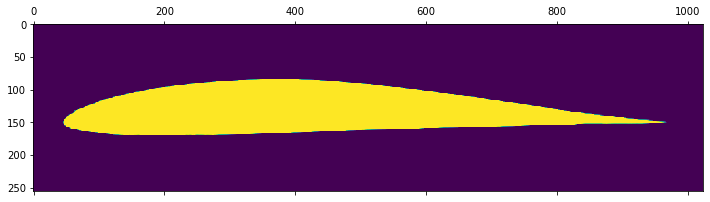

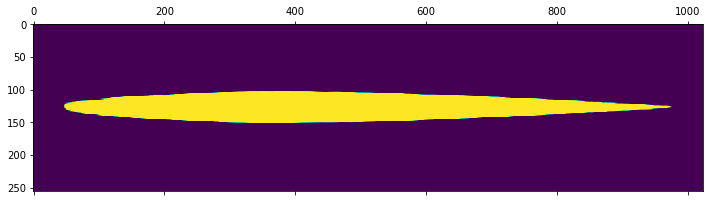

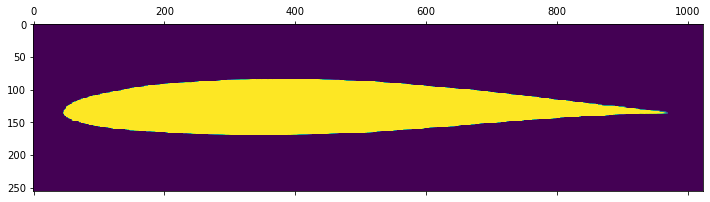

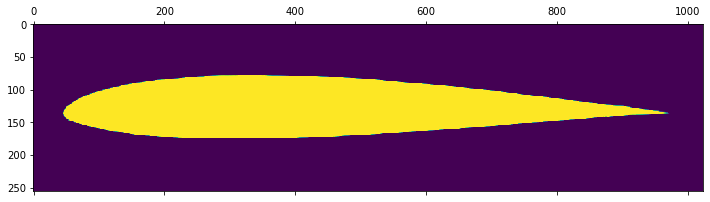

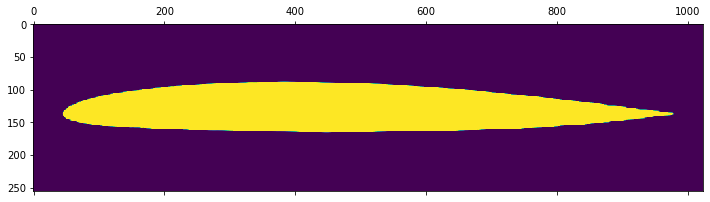

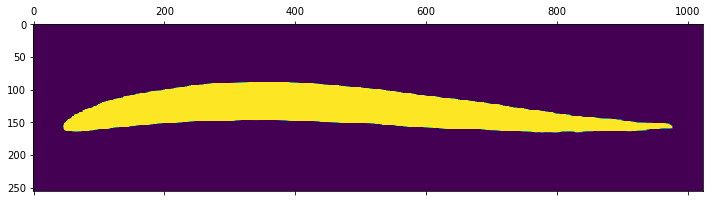

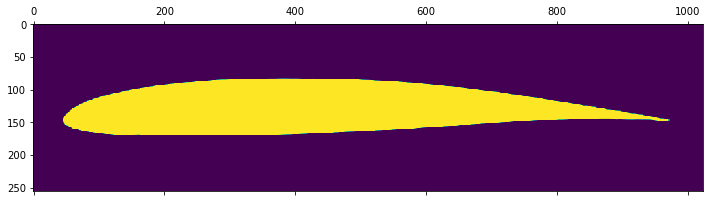

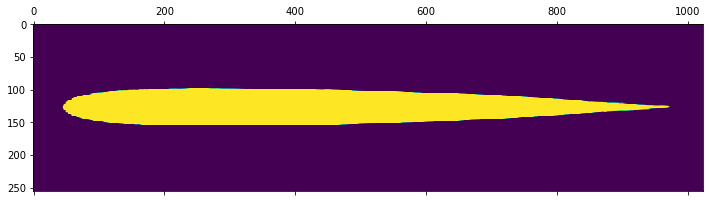

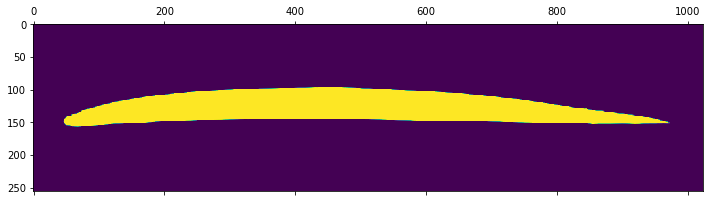

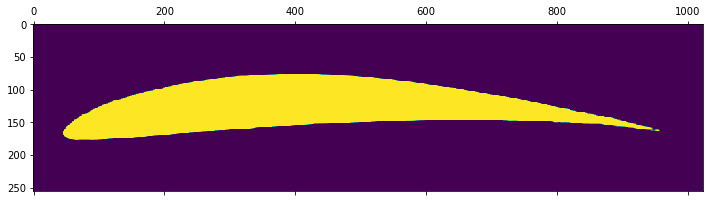

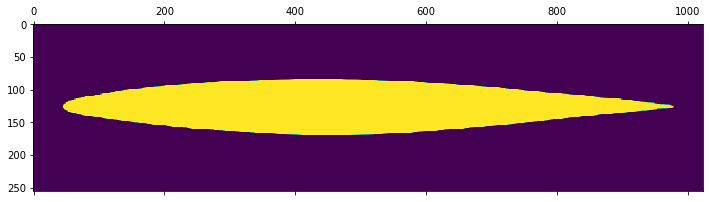

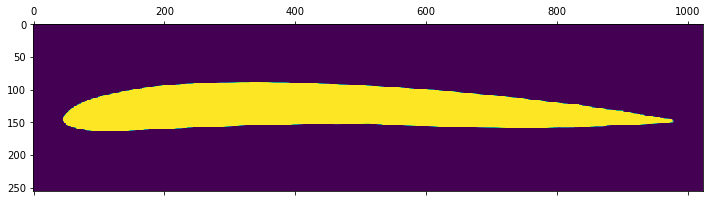

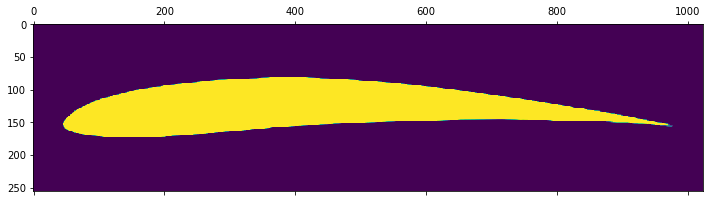

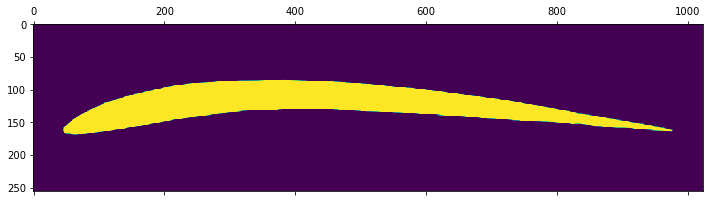

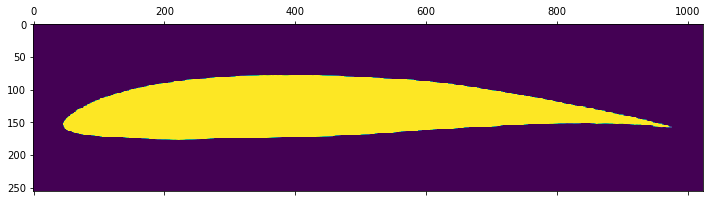

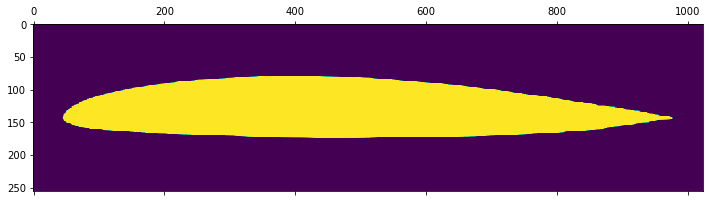

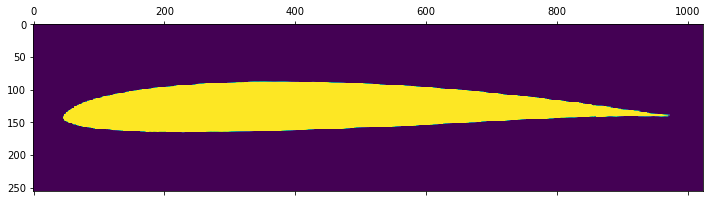

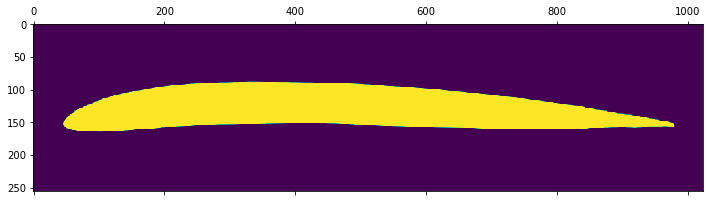

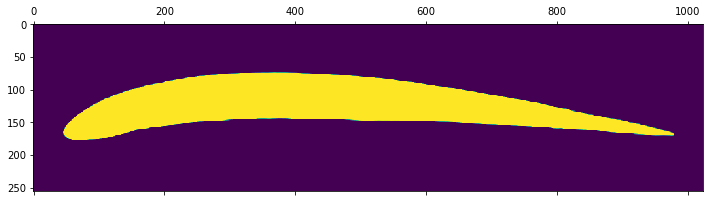

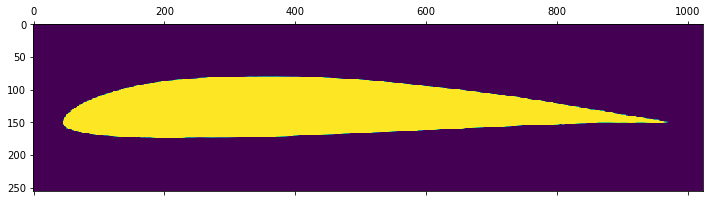

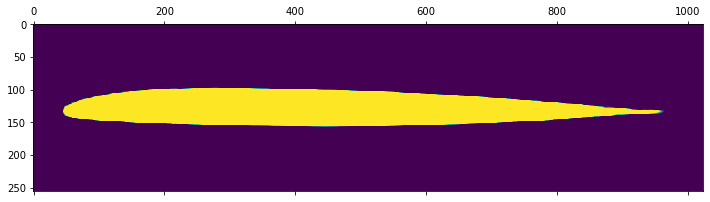

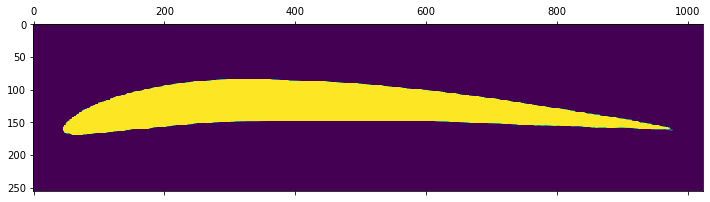

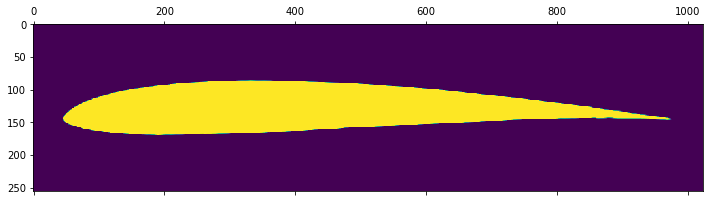

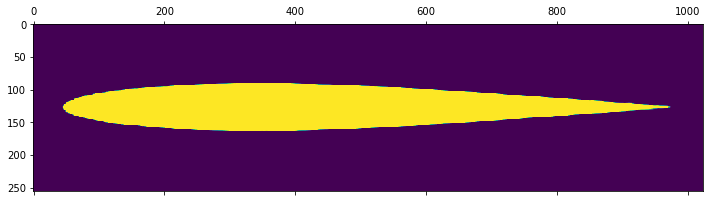

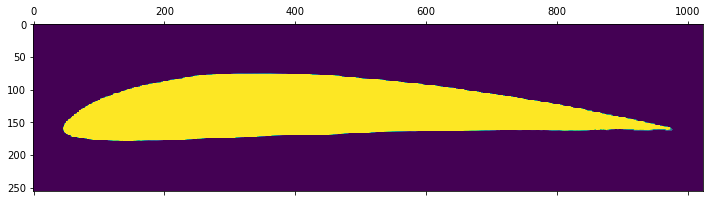

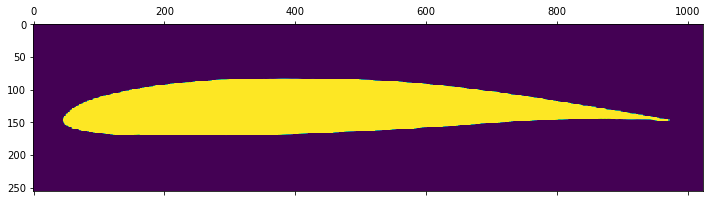

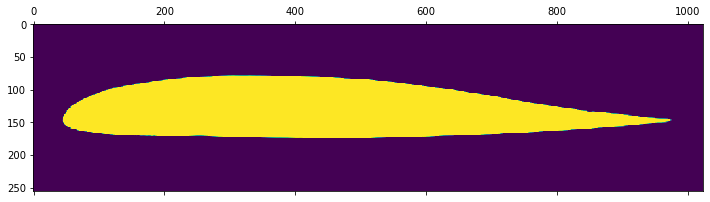

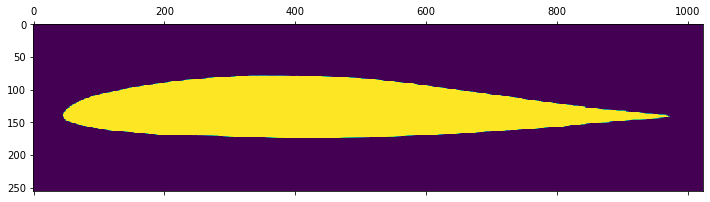

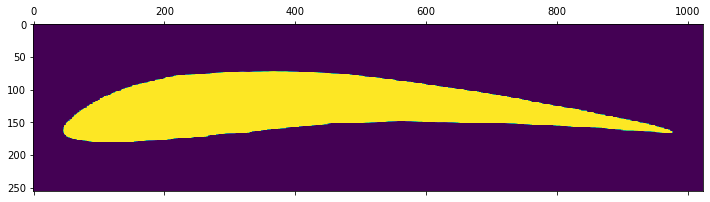

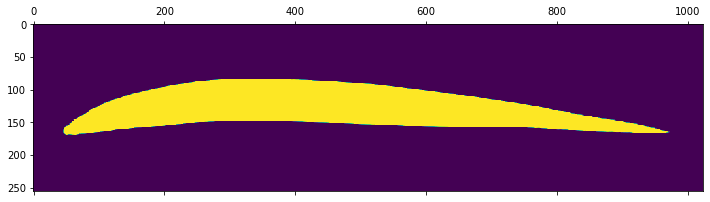

In [11]:
for i in range(30):
    X_test, y_test = generator[i]
    X_test = np.expand_dims(X_test[0], 0)
    y_test = np.expand_dims(y_test[0], 0)

    y_pred = model.predict(X_test)

    plt.figure(figsize=(12,12))
    plt.matshow(y_pred[0,:,:,0],0)

# plt.figure(figsize=(12,12))
# plt.matshow(y_test[0,:,:,0],0)

# plt.figure(figsize=(12,12))
# plt.matshow((np.round(y_pred[0,:,:,0])-y_test[0,:,:,0]),0)

# tr = 0.9

# plt.figure(figsize=(12,12))
# y_pred[0,:,:,0][y_pred[0,:,:,0]>tr]=1
# y_pred[0,:,:,0][y_pred[0,:,:,0]<=tr]=0
# plt.matshow(y_pred[0,:,:,0],0)